# **Import all libraries**

In [9]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# **Hyperparameter**

In [3]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3) 

In [4]:
def plot_image(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    
    plt.show()
    
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()
    
    plt.show()

In [5]:
def evaluate_model(model, validation_generator, title):
    """
    Evaluates model predictions and generates a confusion matrix visualization.

    Parameters:
    - model: Trained model used for predictions.
    - generator: Validation or test data generator.
    - class_indices: Dictionary mapping class names to indices.
    - title (str): Title for the confusion matrix plot.

    Returns:
    - conf_matrix (numpy.ndarray): The computed confusion matrix.
    """

    
    predicted_probabilities = model.predict(validation_generator, verbose=1)
    predicted_classes = (predicted_probabilities >= 0.5).astype(int)

    true_classes = validation_generator.classes 

    print(f"True classes length: {len(true_classes)}")
    print(f"Predicted classes length: {len(predicted_classes)}")

    if len(true_classes) == len(predicted_classes):
        conf_matrix = confusion_matrix(true_classes, predicted_classes)

        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(title)
        plt.show()
    else:
        print("Mismatch in the number of samples between true classes and predicted classes.")

In [6]:
def generate_binary_classification_report(model, generator, class_indices, threshold=0.5):
    """
    Generates a binary classification report for model predictions.

    Parameters:
    - model: Trained model used for predictions.
    - generator: Validation or test data generator.
    - class_indices: Dictionary mapping class names to indices.
    - threshold (float): Threshold for converting predicted probabilities to class labels (default is 0.5).

    Returns:
    - report (str): The classification report as a string.
    """
    predicted_probabilities = model.predict(generator, verbose=1)
    predicted_classes = (predicted_probabilities >= threshold).astype(int)

    true_classes = generator.classes

    if len(true_classes) != len(predicted_classes):
        print("Mismatch in the number of samples between true classes and predicted classes.")
        return None

    report = classification_report(true_classes, predicted_classes, target_names=class_indices.keys())
    
    return report

# **Callbacks**

In [10]:
early_stopping = EarlyStopping(monitor='val_loss',patience=3, restore_best_weights=True) 

checkpoint = ModelCheckpoint(
    filepath='best_model_scratch.keras',      
    monitor='val_loss',            
    save_best_only=True,           
    mode='min',                    
    verbose=1                      
)

# **Load Dataset**

In [8]:
dataset_path = '/kaggle/input/male-and-female-faces-dataset/Male and Female face dataset'

# **Data Preprocessing & Augmentation**

In [11]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2)

In [12]:
train_generator = datagen.flow_from_directory(dataset_path,
                                              batch_size = BATCH_SIZE,
                                              class_mode = 'binary',
                                              target_size = TARGET_SIZE,
                                              color_mode='rgb',
                                              shuffle = True,
                                              subset = 'training')     

validation_generator =  datagen.flow_from_directory(dataset_path,
                                                    batch_size  = BATCH_SIZE,
                                                    class_mode  = 'binary',
                                                    target_size = TARGET_SIZE,
                                                    color_mode='rgb',
                                                    shuffle=False,
                                                    subset = 'validation')

Found 4335 images belonging to 2 classes.
Found 1083 images belonging to 2 classes.


# **Modeling**

**From Scratch**

In [13]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE))  
model.add(BatchNormalization()) 
model.add(MaxPooling2D(pool_size=(2, 2)))  

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization()) 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization()) 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization()) 
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(128 , activation='relu'))
model.add(Dropout(.4))
model.add(Dense(1, activation='sigmoid'))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,490,881 (9.50 MB)

 Trainable params: 2,490,305 (9.50 MB)

 Non-trainable params: 576 (2.25 KB)

In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
history = model.fit(train_generator,
                    epochs=20, 
                    validation_data=validation_generator,
                    verbose=2,
                    callbacks=[checkpoint])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733921874.289103    1789 service.cc:145] XLA service 0x784c98015690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733921874.289193    1789 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733921874.289201    1789 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733921881.549962    1789 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning:


Epoch 1: val_loss improved from inf to 0.83704, saving model to best_model_scratch.keras
136/136 - 174s - 1s/step - accuracy: 0.6641 - loss: 1.1244 - val_accuracy: 0.5023 - val_loss: 0.8370
Epoch 2/20

Epoch 2: val_loss did not improve from 0.83704
136/136 - 159s - 1s/step - accuracy: 0.7428 - loss: 0.5368 - val_accuracy: 0.5679 - val_loss: 1.1202
Epoch 3/20

Epoch 3: val_loss did not improve from 0.83704
136/136 - 154s - 1s/step - accuracy: 0.7659 - loss: 0.4879 - val_accuracy: 0.6039 - val_loss: 0.9186
Epoch 4/20

Epoch 4: val_loss did not improve from 0.83704
136/136 - 153s - 1s/step - accuracy: 0.7912 - loss: 0.4563 - val_accuracy: 0.5789 - val_loss: 1.1844
Epoch 5/20

Epoch 5: val_loss improved from 0.83704 to 0.37883, saving model to best_model_scratch.keras
136/136 - 155s - 1s/step - accuracy: 0.8171 - loss: 0.4033 - val_accuracy: 0.8283 - val_loss: 0.3788
Epoch 6/20

Epoch 6: val_loss improved from 0.37883 to 0.36896, saving model to best_model_scratch.keras
136/136 - 157s - 1

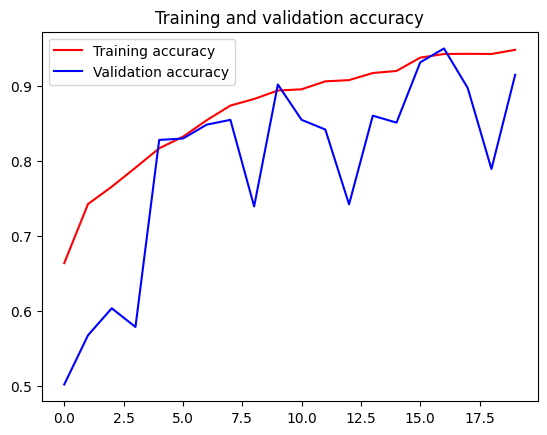

<Figure size 640x480 with 0 Axes>

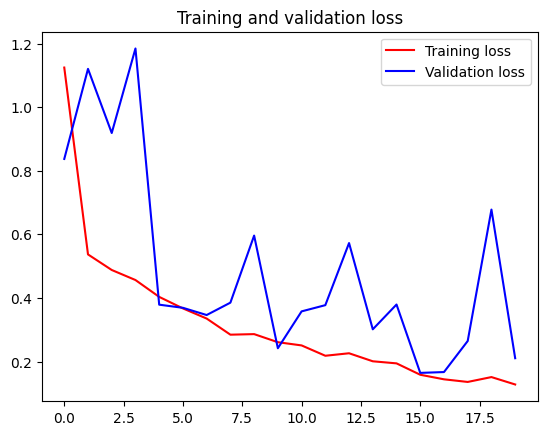

<Figure size 640x480 with 0 Axes>

In [16]:
plot_image(history)

**Transfer Learning with VGG16**

In [22]:
vgg16_model = VGG16(
    input_shape=(224, 224, 3),           
    include_top=False,                   
    weights='imagenet',
    pooling='max'
)

for layer in vgg16_model.layers: 
    layer.trainable = False

In [23]:
x = Flatten()(vgg16_model.output) 
x = Dense(128, activation='relu')(x)  
x = Dropout(0.5)(x) 
x = Dense(1, activation='sigmoid')(x) 


tl1_model = Model(inputs=vgg16_model.input, outputs=x)

tl1_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
tl1_model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
history1 = tl1_model.fit(
    train_generator,
    validation_data=validation_generator,  
    epochs=15,
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


136/136 - 200s - 1s/step - accuracy: 0.7776 - loss: 0.4658 - val_accuracy: 0.8753 - val_loss: 0.3266
Epoch 2/15
136/136 - 154s - 1s/step - accuracy: 0.8614 - loss: 0.3226 - val_accuracy: 0.8864 - val_loss: 0.2971
Epoch 3/15
136/136 - 151s - 1s/step - accuracy: 0.8752 - loss: 0.2887 - val_accuracy: 0.8606 - val_loss: 0.3066
Epoch 4/15
136/136 - 152s - 1s/step - accuracy: 0.8870 - loss: 0.2719 - val_accuracy: 0.9049 - val_loss: 0.2440
Epoch 5/15
136/136 - 151s - 1s/step - accuracy: 0.8983 - loss: 0.2450 - val_accuracy: 0.9040 - val_loss: 0.2570
Epoch 6/15
136/136 - 152s - 1s/step - accuracy: 0.8964 - loss: 0.2410 - val_accuracy: 0.9141 - val_loss: 0.2322
Epoch 7/15
136/136 - 152s - 1s/step - accuracy: 0.9040 - loss: 0.2273 - val_accuracy: 0.9095 - val_loss: 0.2323
Epoch 8/15
136/136 - 153s - 1s/step - accuracy: 0.9082 - loss: 0.2195 - val_accuracy: 0.9187 - val_loss: 0.2068
Epoch 9/15
136/136 - 152s - 1s/step - accuracy: 0.9151 - loss: 0.2074 - val_accuracy: 0.8920 - val_loss: 0.2452
Epo

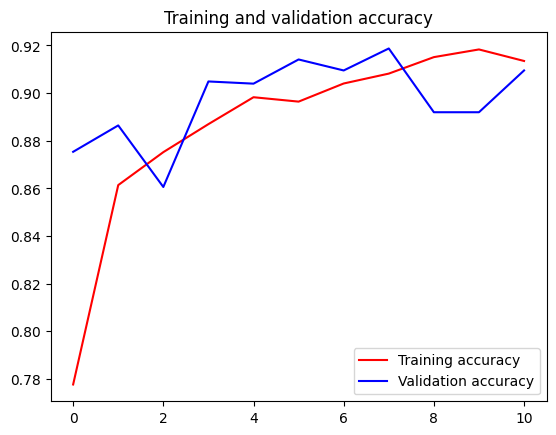

<Figure size 640x480 with 0 Axes>

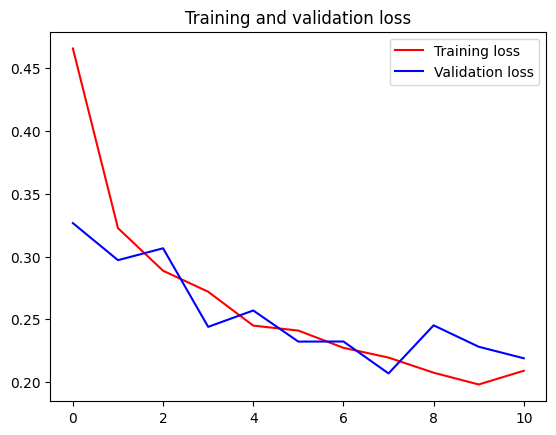

<Figure size 640x480 with 0 Axes>

In [25]:
plot_image(history1)

# **Model Evaluation**

**From Scratch**

34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 890ms/step
True classes length: 1083
Predicted classes length: 1083


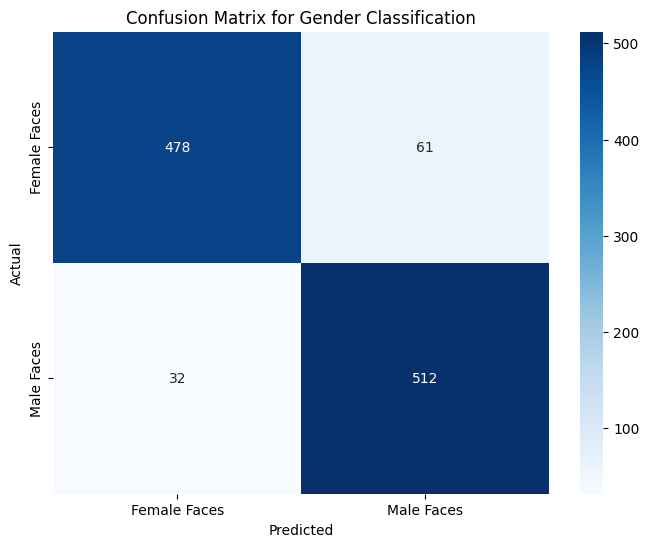

In [18]:
evaluate_model(
    model=model,
    validation_generator=validation_generator,
    title="Confusion Matrix for Gender Classification"
)

In [20]:
report = generate_binary_classification_report(model, validation_generator, class_indices=validation_generator.class_indices)
print(report)

34/34 ━━━━━━━━━━━━━━━━━━━━ 30s 880ms/step
              precision    recall  f1-score   support

Female Faces       0.94      0.90      0.92       539
  Male Faces       0.91      0.94      0.93       544

    accuracy                           0.92      1083
   macro avg       0.93      0.92      0.92      1083
weighted avg       0.92      0.92      0.92      1083



**VGG16**

34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 880ms/step
True classes length: 1083
Predicted classes length: 1083


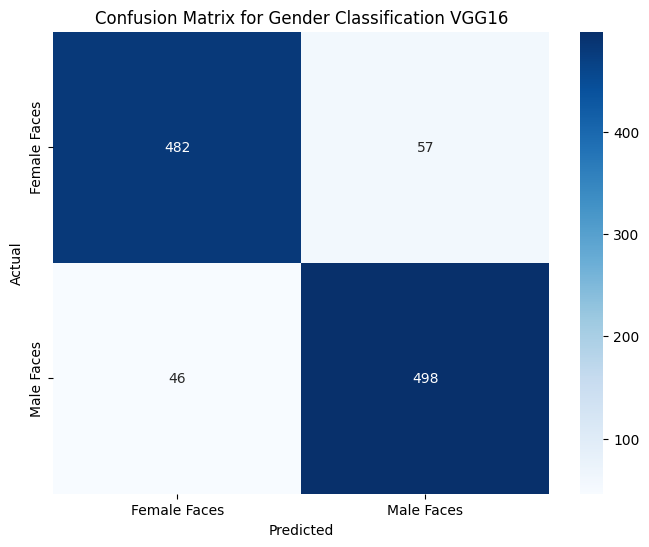

In [26]:
evaluate_model(
    model=tl1_model,
    validation_generator=validation_generator,
    title="Confusion Matrix for Gender Classification VGG16"
)

In [27]:
report = generate_binary_classification_report(tl1_model, validation_generator, class_indices=validation_generator.class_indices)
print(report)

34/34 ━━━━━━━━━━━━━━━━━━━━ 29s 851ms/step
              precision    recall  f1-score   support

Female Faces       0.94      0.90      0.92       539
  Male Faces       0.90      0.95      0.92       544

    accuracy                           0.92      1083
   macro avg       0.92      0.92      0.92      1083
weighted avg       0.92      0.92      0.92      1083



# **Save Model**

In [28]:
tl1_model.save('gender_model_vgg16.h5')